Input the data

In [5]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, box
import osmnx as ox
from pathlib import Path

foodatlas=pd.read_csv("data/Food Access Research Atlas.csv")
snap = pd.read_csv("data/Historical SNAP Retailer Locator Data 2004-2024.csv", 
                   encoding='utf-8', 
                   encoding_errors='replace')
place=gpd.read_file("data/PLACES__Census_Tract_Data_(GIS_Friendly_Format),_2024_release_20251126.geojson")
philly=gpd.read_file("data/City_Limits.geojson")


/var/folders/xm/lcfnqfw931d_v613yc9jpq480000gn/T/ipykernel_14203/480193118.py:8: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  snap = pd.read_csv("data/Historical SNAP Retailer Locator Data 2004-2024.csv",


Filter and reproject the data 

In [6]:
#filter to snap retailers in Philly
phillysnap=snap.loc[snap['County'] == 'PHILADELPHIA']
#select retailers that are still operating
phillysnapfiltered=phillysnap.loc[phillysnap['End Date'].isna()]
#convert to geodataframe
phillygeo = [Point(xy) for xy in zip(phillysnapfiltered['Longitude'], phillysnapfiltered['Latitude'])]
snapgdf=gpd.GeoDataFrame(phillysnapfiltered,geometry=phillygeo)
snapgdf.set_crs(epsg=4326, inplace=True)
snapgdf.to_crs(epsg=2272)

,Record ID,Store Name,Store Type,Street Number,Street Name,Additional Address,City,State,Zip Code,Zip4,County,Latitude,Longitude,Authorization Date,End Date,geometry
544588,1254758,1 Stop Deli & Grocery 1,Convenience Store,3701,Germantown Ave,NaN,Philadelphia,PA,19140,3619,PHILADELPHIA,40.009357,-75.150856,08/23/2016,NaN,POINT (2696471.021 256979.054)
544590,1487550,10 Brothers Food Market Corp,Small Grocery Store,1801,W Venango St,NaN,Philadelphia,PA,19140,4019,PHILADELPHIA,40.008730,-75.158010,04/05/2022,NaN,POINT (2694474.595 256691.847)
544603,1344176,11th & Tioga Mini Market Inc,Small Grocery Store,1047,W Tioga St,NaN,Philadelphia,PA,19140,4348,PHILADELPHIA,40.005505,-75.146450,02/19/2019,NaN,POINT (2697746.064 255612.800)
544607,1044500,1312 DJ Inc. T/A VIP Market,Medium Grocery Store,1312,Walnut St,NaN,Philadelphia,PA,19107,NaN,PHILADELPHIA,39.949135,-75.162680,02/24/2012,NaN,POINT (2693802.947 234953.345)
544610,1351007,16th And York Mini Market Inc,Small Grocery Store,2401,N 16th St,NaN,Philadelphia,PA,19132,4439,PHILADELPHIA,39.989864,-75.158730,05/14/2019,NaN,POINT (2694474.619 249816.317)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553380,1607336,Zamzam Halal Market LLC,Medium Grocery Store,7923,Bustleton Ave,NaN,Philadelphia,PA,19152,3302,PHILADELPHIA,40.057404,-75.052610,08/19/2024,NaN,POINT (2723445.037 275298.901)
553383,1416224,Zapata Mini Market Inc,Small Grocery Store,910,W Duncannon Ave,NaN,Philadelphia,PA,19141,4012,PHILADELPHIA,40.030987,-75.138400,01/11/2021,NaN,POINT (2699725.743 264957.997)
553386,1518283,Zemzem Halal Poultry Inc,Meat/Poultry Specialty,6202,Oxford Ave,NaN,Philadelphia,PA,19111,5810,PHILADELPHIA,40.042240,-75.088760,10/03/2022,NaN,POINT (2713496.878 269470.405)
553392,1228403,Zheng Mini Market,Small Grocery Store,1701,S Bancroft St,NaN,Philadelphia,PA,19145,2204,PHILADELPHIA,39.929653,-75.172410,03/18/2016,NaN,POINT (2691283.231 227779.639)


In [7]:
#filter foodatlas data
foodatlasphilly=foodatlas.loc[foodatlas['County']=='Philadelphia County']
foodatlasphillyfiltered = foodatlasphilly[['CensusTract', 'HUNVFlag', 'TractHUNV', 'TractSNAP']]
#filter the place data to obesity rate only
placefiltered=place[['tractfips','obesity_crudeprev']]
foodatlasphillyfiltered

,CensusTract,HUNVFlag,TractHUNV,TractSNAP
57339,42101000100,0,606.0,12.0
57340,42101000200,0,510.0,95.0
57341,42101000300,0,789.0,32.0
57342,42101000401,0,921.0,202.0
57343,42101000402,0,1150.0,78.0
...,...,...,...,...
57715,42101980300,0,0.0,0.0
57716,42101980700,0,0.0,0.0
57717,42101980800,0,0.0,0.0
57718,42101980900,0,0.0,0.0


Merge atlas data with shapefile

In [8]:
import pygris 
tracts_gdf = pygris.tracts(
    state='42',
    county='101',
    year=2019,
    cache=True
)
tracts_gdf['CensusTract'] = (tracts_gdf['GEOID']).astype(int)
foodatlas_sf = tracts_gdf.merge(
    foodatlasphillyfiltered,
    on='CensusTract',
    how='left'
)

Download census data using API

In [9]:
import pandas as pd
import cenpy
from cenpy import products

acs = cenpy.remote.APIConnection('ACSDT5Y2023')
demographic_vars = [
    "B01003_001E",
    "B02001_003E",
    "B03003_003E",
]

economic_vars = [
    "B19013_001E",
    "B17001_002E",
    "B17001_001E",
    "B23025_005E",
    "B23025_003E",
    "B22003_002E",
    "B22003_001E",
]

all_vars = demographic_vars + economic_vars

var_names = {
    "B01003_001E": "total_population",
    "B02001_003E": "black_alone",
    "B03003_003E": "hispanic_latino",
    "B19013_001E": "median_household_income",
    "B17001_002E": "poverty_total",
    "B17001_001E": "poverty_universe",
    "B23025_005E": "unemployed",
    "B23025_003E": "labor_force",
    "B22003_002E": "snap_recipients",
    "B22003_001E": "snap_universe",
}

census_data = acs.query(
    cols=all_vars,
    geo_unit='tract',
    geo_filter={
        'state': '42',
        'county': '101'
    }
)

print(f"Downloaded {len(census_data)} census tracts")


census_data.rename(columns=var_names, inplace=True)


for col in var_names.values():
    census_data[col] = pd.to_numeric(census_data[col], errors='coerce')

print("Calculating derived metrics...")

census_data["poverty_rate"] = census_data["poverty_total"] / census_data["poverty_universe"] * 100
census_data["unemployment_rate"] = census_data["unemployed"] / census_data["labor_force"] * 100
census_data["snap_rate"] = census_data["snap_recipients"] / census_data["snap_universe"] * 100
census_data["pct_black"] = census_data["black_alone"] / census_data["total_population"] * 100
census_data["pct_hispanic"] = census_data["hispanic_latino"] / census_data["total_population"] * 100

print("Done.")


Downloaded 408 census tracts
Calculating derived metrics...
Done.


Merge Census data with shapefile

In [10]:
import pygris 
tracts_gdf = pygris.tracts(
    state='42',
    county='101',
    year=2023,
    cache=True
)
tracts_gdf['tract'] = tracts_gdf['TRACTCE']
merged_gdf = tracts_gdf.merge(
    census_data[["median_household_income",'poverty_rate',"unemployment_rate","snap_rate","pct_black","pct_hispanic",'state', 'county','tract']],
    on='tract',
    how='left'
)

Download POI from OSM

In [11]:
foodstore = ox.features_from_place(
    "Philadelphia, PA", tags={"shop": ["food", "supermarket", "grocery"]}
)

foodstore_proj=foodstore.to_crs(epsg=2272)
foodstore_proj

/opt/anaconda3/envs/geospatial/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/geospatial/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/opt/anaconda3/envs/geospatial/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/geospatial/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/geospatial/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/geospatial/lib/python3.10/site-packages/shapely/predicates.py:798: Runt

addr:city addr:housenumber addr:postcode  \
element_type osmid                                                     
node         333786275   Philadelphia              929         19147   
             412338071   Philadelphia             6901         19128   
             977690451   Philadelphia              180         19123   
             1698143876           NaN              NaN           NaN   
             1702834399  Philadelphia              146           NaN   
...                               ...              ...           ...   
way          1218089830  Philadelphia             1255         19125   
             1218306122  Philadelphia             2200         19125   
             1220520339  Philadelphia             2852         19133   
             1305649715  Philadelphia             7298         19153   
             1315830027           NaN              NaN           NaN   

                        addr:state         addr:street        branch  \
element_type osmid                                                     
node         333786275          PA        South Street  South Street   
             412338071          PA        Ridge Avenue    Roxborough   
             977690451          PA  West Girard Avenue           NaN   
             1698143876        NaN                 NaN           NaN   
             1702834399        NaN   North 10th Street           NaN   
...                            ...                 ...           ...   
way          1218089830         PA  East Palmer Street           NaN   
             1218306122         PA  East Norris Street           NaN   
             1220520339         PA  North Front Street           NaN   
             1305649715         PA     Woodland Avenue           NaN   
             1315830027        NaN                 NaN           NaN   

                                          brand brand:wikidata  check_date  \
element_type osmid                                                           
node         333786275       Whole Foods Market       Q1809448  2025-10-25   
             412338071                 ShopRite       Q7501097  2023-09-27   
             977690451                     Acme        Q341975  2024-04-06   
             1698143876                     NaN            NaN         NaN   
             1702834399                     NaN            NaN         NaN   
...                                         ...            ...         ...   
way          1218089830                     NaN            NaN         NaN   
             1218306122                     NaN            NaN         NaN   
             1220520339                     NaN            NaN         NaN   
             1305649715                     NaN            NaN         NaN   
             1315830027  Sprouts Farmers Market       Q7581369         NaN   

                        check_date:opening_hours  ... diet:natural_foods  \
element_type osmid                                ...                      
node         333786275                2025-10-25  ...                NaN   
             412338071                       NaN  ...                NaN   
             977690451                       NaN  ...                NaN   
             1698143876                      NaN  ...                NaN   
             1702834399                      NaN  ...                NaN   
...                                          ...  ...                ...   
way          1218089830                      NaN  ...                NaN   
             1218306122                      NaN  ...                NaN   
             1220520339                      NaN  ...                NaN   
             1305649715                      NaN  ...                NaN   
             1315830027                      NaN  ...                NaN   

                        diet:vegan diet:vegetarian diet:halal level  \
element_type osmid                                                    
node    

Create a grid containing potential index

In [12]:
import numpy as np
grid_size = 50  # meters
minx, miny, maxx, maxy = philly.total_bounds
x_coords = np.arange(minx, maxx + grid_size, grid_size)
y_coords = np.arange(miny, maxy + grid_size, grid_size)

In [13]:
# START FROM SCRATCH with correct bounds
philly_proj = philly.to_crs(epsg=2272)
minx, miny, maxx, maxy = philly_proj.total_bounds  # Get PROJECTED bounds

grid_size = 50  # meters (makes sense in EPSG:2272)
x_coords = np.arange(minx, maxx + grid_size, grid_size)
y_coords = np.arange(miny, maxy + grid_size, grid_size)

print(f"Creating {len(x_coords)-1} x {len(y_coords)-1} grid = {(len(x_coords)-1)*(len(y_coords)-1)} cells")

# Create grid
from shapely.geometry import box
polygons = []
for x in x_coords[:-1]:
    for y in y_coords[:-1]:
        polygons.append(box(x, y, x + grid_size, y + grid_size))

grid = gpd.GeoDataFrame({'geometry': polygons}, crs='EPSG:2272')
print(f"Grid created: {len(grid)} cells")

# Clip to Philadelphia boundary
grid = gpd.overlay(grid, philly_proj, how='intersection')
print(f"After clipping to Philly: {len(grid)} cells")

# Continue with your network analysis...
grid['centroid'] = grid.centroid
centroids = grid.set_geometry('centroid')

Creating 1791 x 2003 grid = 3587373 cells
Grid created: 3587373 cells


/opt/anaconda3/envs/geospatial/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


After clipping to Philly: 1593448 cells


Calculate the nearest distance to snap retailer and foodstore using networking analysis

In [14]:
G = ox.graph_from_place("Philadelphia, Pennsylvania, USA", network_type='drive')
G = ox.project_graph(G, to_crs="EPSG:2272")
foodstore_proj['geometry'] = foodstore_proj.geometry.centroid
foodstore_proj_x = foodstore_proj.geometry.x.values
foodstore_proj_y = foodstore_proj.geometry.y.values

centroid_nodes = ox.distance.nearest_nodes(G,
                                           X=centroids.geometry.x.values,
                                           Y=centroids.geometry.y.values)
food_nodes = ox.distance.nearest_nodes(G,
                                       X=foodstore_proj_x,
                                       Y=foodstore_proj_y)
snap_nodes = ox.distance.nearest_nodes(G,
                                       X=snapgdf.geometry.x.values,
                                       Y=snapgdf.geometry.y.values)


/opt/anaconda3/envs/geospatial/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/geospatial/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/geospatial/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/opt/anaconda3/envs/geospatial/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/geospatial/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


In [20]:
import networkx as nx

print("Calculating distances to food stores...")
food_dist_dict = nx.multi_source_dijkstra_path_length(G, food_nodes, weight='length')

print("Calculating distances to SNAP retailers...")
snap_dist_dict = nx.multi_source_dijkstra_path_length(G, snap_nodes, weight='length')

# Map distances back to centroids
centroids['dist_food_ft'] = [food_dist_dict.get(n, np.nan) for n in centroid_nodes]
centroids['dist_snap_ft'] = [snap_dist_dict.get(n, np.nan) for n in centroid_nodes]

# Convert to meters if desired
centroids['dist_food_m'] = centroids['dist_food_ft'] * 0.3048
centroids['dist_snap_m'] = centroids['dist_snap_ft'] * 0.3048

grid['dist_food_ft'] = centroids['dist_food_ft'].values
grid['dist_snap_ft'] = centroids['dist_snap_ft'].values
grid['dist_food_m'] = centroids['dist_food_m'].values
grid['dist_snap_m'] = centroids['dist_snap_m'].values
grid


Calculating distances to food stores...
Calculating distances to SNAP retailers...


,objectid,Shape__Area,Shape__Length,geometry,centroid,dist_food_ft,dist_snap_ft,dist_food_m,dist_snap_m
0,1,6.295179e+08,157172.791716,"POLYGON ((2660623.916 243366.121, 2660623.916 ...",POINT (2660619.165 243356.846),798.80,0.000,243.474240,0.000000
1,1,6.295179e+08,157172.791716,"POLYGON ((2660623.916 243416.121, 2660623.916 ...",POINT (2660608.440 243395.379),798.80,0.000,243.474240,0.000000
2,1,6.295179e+08,157172.791716,"POLYGON ((2660623.916 243416.121, 2660580.851 ...",POINT (2660604.682 243432.917),798.80,0.000,243.474240,0.000000
3,1,6.295179e+08,157172.791716,"POLYGON ((2660673.916 243266.121, 2660673.916 ...",POINT (2660665.578 243253.163),798.80,0.000,243.474240,0.000000
4,1,6.295179e+08,157172.791716,"POLYGON ((2660673.916 243316.121, 2660673.916 ...",POINT (2660657.075 243293.545),798.80,0.000,243.474240,0.000000
...,...,...,...,...,...,...,...,...,...
1593443,1,6.295179e+08,157172.791716,"POLYGON ((2750073.916 289766.121, 2750088.352 ...",POINT (2750078.783 289749.792),1640.46,33461.767,500.012208,10199.146582
1593444,1,6.295179e+08,157172.791716,"POLYGON ((2750073.916 289766.121, 2750073.916 ...",POINT (2750085.111 289793.885),1640.46,33461.767,500.012208,10199.146582
1593445,1,6.295179e+08,157172.791716,"POLYGON ((2750073.916 289816.121, 2750073.916 ...",POINT (2750091.301 289842.159),1640.46,33461.767,500.012208,10199.146582
1593446,1,6.295179e+08,157172.791716,"POLYGON ((2750073.916 289866.121, 2750073.916 ...",POINT (2750088.659 289887.940),1640.46,33461.767,500.012208,10199.146582


Join the census data and food atlas with the grid

In [21]:
merged_gdf_proj = merged_gdf.to_crs(epsg=2272)
foodatlas_proj=foodatlas_sf.to_crs(epsg=2272)

grid['centroid'] = grid.centroid  
grid_centroids = grid.set_geometry('centroid')

grid_with_census = gpd.sjoin(grid_centroids, merged_gdf_proj, 
                              how='left', predicate='within',
                              lsuffix='', rsuffix='_census')

# Second spatial join with foodatlas - join to the result of first join
grid_with_both = gpd.sjoin(grid_with_census, foodatlas_proj, 
                            how='left', predicate='within',
                            lsuffix='', rsuffix='_foodatlas')

# Merge back to grid to restore polygon geometry
grid_final = grid.merge(
    grid_with_both.drop(columns=['geometry']), 
    left_index=True, 
    right_index=True
)

The food desert index is constructed as a weighted composite measure (0-100 scale) that captures the multidimensional nature of food access barriers in Philadelphia. The index allocates 30% weight to physical accessibility, measured through network distances to both conventional food stores and SNAP-accepting retailers, recognizing that proximity alone determines whether residents can reasonably reach food sources. Economic vulnerability receives the highest weight at 35%, incorporating poverty rates, SNAP participation, unemployment, and median household income, as financial constraints fundamentally limit food purchasing power regardless of store proximity. Transportation barriers comprise 25% of the index, emphasizing the critical role of vehicle access through the HUNVFlag indicator (identifying tracts with ≥100 households lacking vehicles and located >0.5 miles from supermarkets) and the TractHUNV measure, since transportation constraints create compounding disadvantages when combined with distance. Finally, demographic factors account for 10% of the index through minority population percentages (Black and Hispanic), acknowledging research showing that predominantly minority neighborhoods often face additional systemic barriers to food access including store quality, pricing disparities, and historical disinvestment patterns. This weighting structure reflects the understanding that food deserts emerge from the intersection of spatial, economic, transportation, and social inequities, with economic and transportation barriers being particularly determinative of whether households can achieve adequate food security even when stores exist within reasonable distances.

In [31]:
# Clean up the dataframe first
grid_clean = grid_final.copy()

# Drop duplicate columns
cols_to_drop = [
    'objectid_y', 'Shape__Area_y', 'Shape__Length_y', 
    'centroid_y', 'dist_food_ft_y', 'dist_snap_ft_y', 
    'dist_food_m_y', 'dist_snap_m_y',
    'index__census', 'index__foodatlas',
    'STATEFP__foodatlas', 'COUNTYFP__foodatlas', 'TRACTCE__foodatlas',
    'GEOID__foodatlas', 'NAME__foodatlas', 'NAMELSAD__foodatlas',
    'MTFCC__foodatlas', 'FUNCSTAT__foodatlas', 'ALAND__foodatlas',
    'AWATER__foodatlas', 'INTPTLAT__foodatlas', 'INTPTLON__foodatlas'
]

grid_clean = grid_clean.drop(columns=[col for col in cols_to_drop if col in grid_clean.columns])

# Rename columns
rename_dict = {
    'objectid_x': 'objectid',
    'Shape__Area_x': 'Shape__Area',
    'Shape__Length_x': 'Shape__Length',
    'centroid_x': 'centroid',
    'dist_food_ft_x': 'dist_food_ft',
    'dist_snap_ft_x': 'dist_snap_ft',
    'dist_food_m_x': 'dist_food_m',
    'dist_snap_m_x': 'dist_snap_m',
}

grid_clean = grid_clean.rename(columns={k: v for k, v in rename_dict.items() if k in grid_clean.columns})

print(f"Cleaned grid: {len(grid_clean)} cells")

# ===== CREATE COMPREHENSIVE FOOD DESERT INDEX =====

# Convert distances to miles
grid_clean['dist_food_mi'] = grid_clean['dist_food_m'] / 1609.34
grid_clean['dist_snap_mi'] = grid_clean['dist_snap_m'] / 1609.34

# ===== 1. ACCESSIBILITY COMPONENT (0-1 scale) =====
# Distance to regular food stores (higher = worse)
grid_clean['food_distance_score'] = np.minimum(grid_clean['dist_food_mi'] / 2, 1)  # Cap at 2 miles

# Distance to SNAP retailers (higher = worse)
grid_clean['snap_distance_score'] = np.minimum(grid_clean['dist_snap_mi'] / 1.5, 1)  # Cap at 1.5 miles

# Combined accessibility score (average of both distances)
grid_clean['accessibility_score'] = (
    0.6 * grid_clean['food_distance_score'] + 
    0.4 * grid_clean['snap_distance_score']
)

# ===== 2. ECONOMIC VULNERABILITY COMPONENT (0-1 scale) =====
# Poverty rate (already a percentage)
grid_clean['poverty_score'] = grid_clean['poverty_rate'] / 100

# SNAP participation rate
grid_clean['snap_participation_score'] = grid_clean['snap_rate'] / 100

# Unemployment rate
grid_clean['unemployment_score'] = grid_clean['unemployment_rate'] / 100

# Median income (inverse normalized - lower income = higher vulnerability)
income_max = grid_clean['median_household_income'].quantile(0.95)
income_min = grid_clean['median_household_income'].quantile(0.05)
grid_clean['income_score'] = 1 - (
    (grid_clean['median_household_income'] - income_min) / (income_max - income_min)
).clip(0, 1)

# Combined economic vulnerability (weighted average)
grid_clean['economic_vulnerability'] = (
    0.30 * grid_clean['poverty_score'] +
    0.25 * grid_clean['snap_participation_score'] +
    0.25 * grid_clean['unemployment_score'] +
    0.20 * grid_clean['income_score']
)

# ===== 3. TRANSPORTATION BARRIER COMPONENT (0-1 scale) =====
# HUNVFlag: >= 100 households without vehicle AND > 0.5 mile from supermarket
grid_clean['hunv_flag_score'] = grid_clean['HUNVFlag'].fillna(0)

# TractHUNV: Number/proportion of households with low vehicle access and low food access
# Normalize this if it's a count, or use as-is if it's already a proportion
if grid_clean['TractHUNV'].max() > 1:
    # If it's a count, normalize it
    tracthunv_max = grid_clean['TractHUNV'].quantile(0.95)
    grid_clean['tracthunv_score'] = (grid_clean['TractHUNV'] / tracthunv_max).clip(0, 1).fillna(0)
else:
    # If it's already a proportion (0-1)
    grid_clean['tracthunv_score'] = grid_clean['TractHUNV'].fillna(0)

# Combined transportation barrier score
# Give more weight to HUNVFlag as it's a clear binary indicator of severe access issues
grid_clean['transportation_barrier'] = (
    0.60 * grid_clean['hunv_flag_score'] +
    0.40 * grid_clean['tracthunv_score']
)

# ===== 4. DEMOGRAPHIC VULNERABILITY COMPONENT (0-1 scale) =====
# Minority populations often face additional barriers to food access
grid_clean['black_score'] = grid_clean['pct_black'] / 100
grid_clean['hispanic_score'] = grid_clean['pct_hispanic'] / 100

# Combined minority percentage (cap at 100%)
grid_clean['minority_score'] = np.minimum(
    (grid_clean['pct_black'] + grid_clean['pct_hispanic']) / 100,
    1.0
)

# ===== 5. COMPREHENSIVE FOOD DESERT INDEX (0-100 scale) =====
# Weighted combination of all components
grid_clean['food_desert_index'] = (
    0.30 * grid_clean['accessibility_score'] * 100 +          # 30% - Distance to food
    0.35 * grid_clean['economic_vulnerability'] * 100 +       # 35% - Economic factors
    0.25 * grid_clean['transportation_barrier'] * 100 +       # 25% - Vehicle access barriers
    0.10 * grid_clean['minority_score'] * 100                 # 10% - Demographic factors
)

# ===== 6. CATEGORICAL CLASSIFICATION =====
def classify_food_desert(row):
    if pd.isna(row['food_desert_index']):
        return 'No Data'
    elif row['food_desert_index'] >= 80:
        return 'Severe Food Desert'
    elif row['food_desert_index'] >= 60:
        return 'High Risk'
    elif row['food_desert_index'] >= 40:
        return 'Moderate Risk'
    elif row['food_desert_index'] >= 20:
        return 'Low Risk'
    else:
        return 'Good Access'

grid_clean['food_desert_category'] = grid_clean.apply(classify_food_desert, axis=1)

# ===== 7. SPECIAL FLAG: Critical Access Barrier =====
# Areas with BOTH no vehicle access AND far from food
grid_clean['critical_barrier'] = (
    (grid_clean['HUNVFlag'] == 1) & 
    (grid_clean['dist_food_mi'] > 0.5)
)

# ===== 8. USDA DEFINITION (for comparison) =====
grid_clean['usda_low_income'] = (
    (grid_clean['poverty_rate'] > 20) | 
    (grid_clean['median_household_income'] < grid_clean['median_household_income'].median() * 0.8)
)
grid_clean['usda_low_access'] = grid_clean['dist_food_mi'] > 1.0
grid_clean['usda_food_desert'] = grid_clean['usda_low_income'] & grid_clean['usda_low_access']

# ===== SUMMARY STATISTICS =====
print("\n" + "="*70)
print("COMPREHENSIVE FOOD DESERT INDEX SUMMARY")
print("="*70)

print("\n1. OVERALL INDEX (0-100, higher = worse):")
print(grid_clean['food_desert_index'].describe())

print("\n2. COMPONENT SCORES (0-100):")
print(f"   Accessibility (distance):         {grid_clean['accessibility_score'].mean()*100:.1f}")
print(f"   Economic Vulnerability:           {grid_clean['economic_vulnerability'].mean()*100:.1f}")
print(f"   Transportation Barriers:          {grid_clean['transportation_barrier'].mean()*100:.1f}")
print(f"   Demographic Vulnerability:        {grid_clean['minority_score'].mean()*100:.1f}")

print("\n3. TRANSPORTATION BARRIER DETAILS:")
print(f"   Areas with HUNVFlag=1:            {grid_clean['HUNVFlag'].sum()} cells ({grid_clean['HUNVFlag'].sum()/len(grid_clean)*100:.1f}%)")
print(f"   Areas with critical barriers:     {grid_clean['critical_barrier'].sum()} cells")
print(f"   (HUNVFlag=1 AND >0.5mi from food)")

print("\n4. CATEGORY DISTRIBUTION:")
print(grid_clean['food_desert_category'].value_counts().sort_index())

print("\n5. USDA FOOD DESERT DEFINITION:")
print(f"   Low Income Areas:                 {grid_clean['usda_low_income'].sum()} cells")
print(f"   Low Access Areas:                 {grid_clean['usda_low_access'].sum()} cells")
print(f"   USDA Food Deserts:                {grid_clean['usda_food_desert'].sum()} cells")

print("\n6. HIGH-RISK AREAS:")
high_risk = grid_clean[grid_clean['food_desert_category'].isin(['Severe Food Desert', 'High Risk'])]
print(f"   Total high-risk cells:            {len(high_risk)}")
print(f"   Avg distance to food:             {high_risk['dist_food_mi'].mean():.2f} miles")
print(f"   Avg distance to SNAP:             {high_risk['dist_snap_mi'].mean():.2f} miles")
print(f"   Avg poverty rate:                 {high_risk['poverty_rate'].mean():.1f}%")
print(f"   Avg unemployment:                 {high_risk['unemployment_rate'].mean():.1f}%")
print(f"   With HUNVFlag:                    {high_risk['HUNVFlag'].sum()} cells ({high_risk['HUNVFlag'].sum()/len(high_risk)*100:.1f}%)")
print(f"   With critical barriers:           {high_risk['critical_barrier'].sum()} cells")

print("\n7. AREAS WITH CRITICAL TRANSPORTATION BARRIERS:")
critical = grid_clean[grid_clean['critical_barrier']]
if len(critical) > 0:
    print(f"   Total cells:                      {len(critical)}")
    print(f"   Avg food desert index:            {critical['food_desert_index'].mean():.1f}")
    print(f"   Avg distance to food:             {critical['dist_food_mi'].mean():.2f} miles")
    print(f"   Avg poverty rate:                 {critical['poverty_rate'].mean():.1f}%")
    print(f"   Avg minority percentage:          {(critical['pct_black'].mean() + critical['pct_hispanic'].mean()):.1f}%")

print("\n" + "="*70)

# Show worst areas
print("\nTOP 10 WORST FOOD DESERT AREAS:")
worst_areas = grid_clean.nlargest(10, 'food_desert_index')[
    ['food_desert_index', 'dist_food_mi', 'dist_snap_mi', 
     'poverty_rate', 'unemployment_rate', 'HUNVFlag', 'critical_barrier',
     'pct_black', 'pct_hispanic']
]
print(worst_areas.to_string())

Cleaned grid: 1593448 cells

COMPREHENSIVE FOOD DESERT INDEX SUMMARY

1. OVERALL INDEX (0-100, higher = worse):
count    1.291573e+06
mean     3.151645e+01
std      1.146236e+01
min      1.263125e+01
25%      2.147543e+01
50%      3.017080e+01
75%      3.885154e+01
max      6.442736e+01
Name: food_desert_index, dtype: float64

2. COMPONENT SCORES (0-100):
   Accessibility (distance):         47.1
   Economic Vulnerability:           14.2
   Transportation Barriers:          26.9
   Demographic Vulnerability:        47.3

3. TRANSPORTATION BARRIER DETAILS:
   Areas with HUNVFlag=1:            365831.0 cells (23.0%)
   Areas with critical barriers:     30599 cells
   (HUNVFlag=1 AND >0.5mi from food)

4. CATEGORY DISTRIBUTION:
Good Access      220047
High Risk          7964
Low Risk         778803
Moderate Risk    284759
No Data          301875
Name: food_desert_category, dtype: int64

5. USDA FOOD DESERT DEFINITION:
   Low Income Areas:                 824936 cells
   Low Access Areas: 

Exporting Geojson

In [42]:
from geopandas.array import GeometryDtype
import geopandas as gpd

# Start from your cleaned grid
grid_export = grid_clean.copy()

# Identify geometry-type columns
geom_cols = [
    c for c in grid_export.columns
    if isinstance(grid_export[c].dtype, GeometryDtype)
]

print("Geometry columns detected:", geom_cols)

# Keep only the polygon grid geometry
keep_geom = "geometry"
extra_geom = [col for col in geom_cols if col != keep_geom]

# Drop centroid and any other geometry columns
grid_export = grid_export.drop(columns=extra_geom, errors="ignore")

# Set the active geometry explicitly
grid_export = grid_export.set_geometry(keep_geom)

# Reproject for GeoJSON (important: use to_crs(), not set_crs())
grid_export = grid_export.to_crs(epsg=4326)

# Export
geojson_path = "outputs/philly_food_desert_grid.geojson"
grid_export.to_file(
    geojson_path,
    driver="GeoJSON",
    engine="pyogrio"
)

print("Export complete:", geojson_path)


Geometry columns detected: ['geometry', 'centroid']
Export complete: outputs/philly_food_desert_grid.geojson


Distribution of the Index

Food Desert Index summary:
count    1.291573e+06
mean     3.151645e+01
std      1.146236e+01
min      1.263125e+01
25%      2.147543e+01
50%      3.017080e+01
75%      3.885154e+01
max      6.442736e+01
Name: food_desert_index, dtype: float64

Category counts:
Low Risk         778803
No Data          301875
Moderate Risk    284759
Good Access      220047
High Risk          7964
Name: food_desert_category, dtype: int64


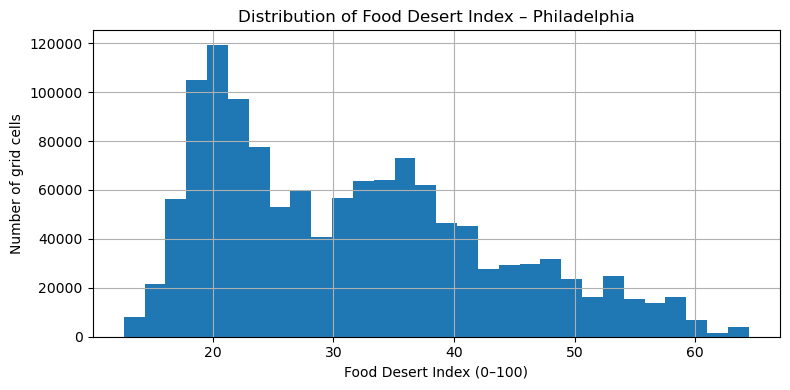

In [43]:
import matplotlib.pyplot as plt

# Basic summary of the index and categories
print("Food Desert Index summary:")
print(grid_clean["food_desert_index"].describe())

print("\nCategory counts:")
print(grid_clean["food_desert_category"].value_counts())

# Histogram of the index
fig, ax = plt.subplots(figsize=(8, 4))
grid_clean["food_desert_index"].hist(bins=30, ax=ax)
ax.set_xlabel("Food Desert Index (0–100)")
ax.set_ylabel("Number of grid cells")
ax.set_title("Distribution of Food Desert Index – Philadelphia")
plt.tight_layout()
plt.show()


Map: food desert categories across the grid

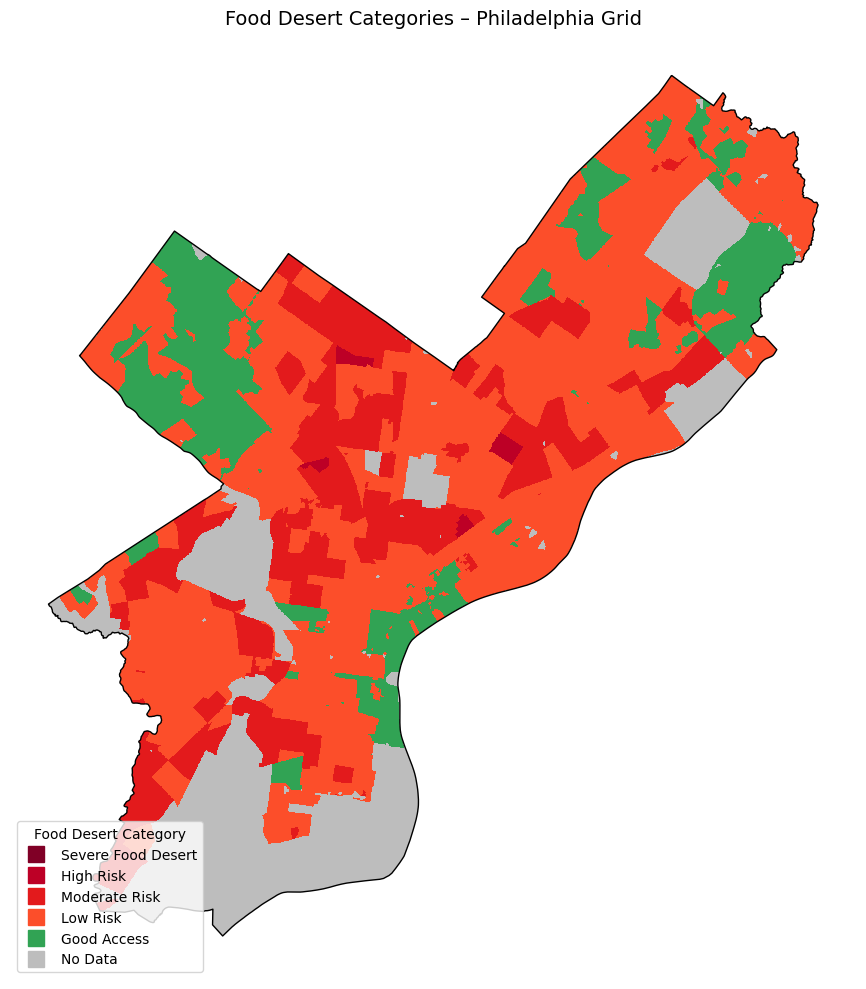

In [44]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define a color for each category — in order
category_colors = {
    "Severe Food Desert": "#800026",   # dark red
    "High Risk": "#BD0026",            # red
    "Moderate Risk": "#E31A1C",        # orange-red
    "Low Risk": "#FC4E2A",             # orange
    "Good Access": "#31a354",          # green
    "No Data": "#bdbdbd"               # gray
}

# Create a column with colors for plotting
grid_clean["category_color"] = grid_clean["food_desert_category"].map(category_colors)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Outline of the city
philly_proj = philly.to_crs(grid_clean.crs)
philly_proj.boundary.plot(ax=ax, linewidth=1, color="black")

# Plot grid cells using custom color column
grid_clean.plot(
    color=grid_clean["category_color"],
    ax=ax,
    linewidth=0
)

# Create custom legend
handles = [
    plt.Line2D(
        [0], [0],
        marker='s', color=category_colors[c], label=c,
        markersize=12, linestyle='None'
    )
    for c in category_colors
]

ax.legend(
    handles=handles,
    title="Food Desert Category",
    loc="lower left",
    frameon=True
)

ax.set_title("Food Desert Categories – Philadelphia Grid", fontsize=14)
ax.set_axis_off()

plt.tight_layout()
plt.show()


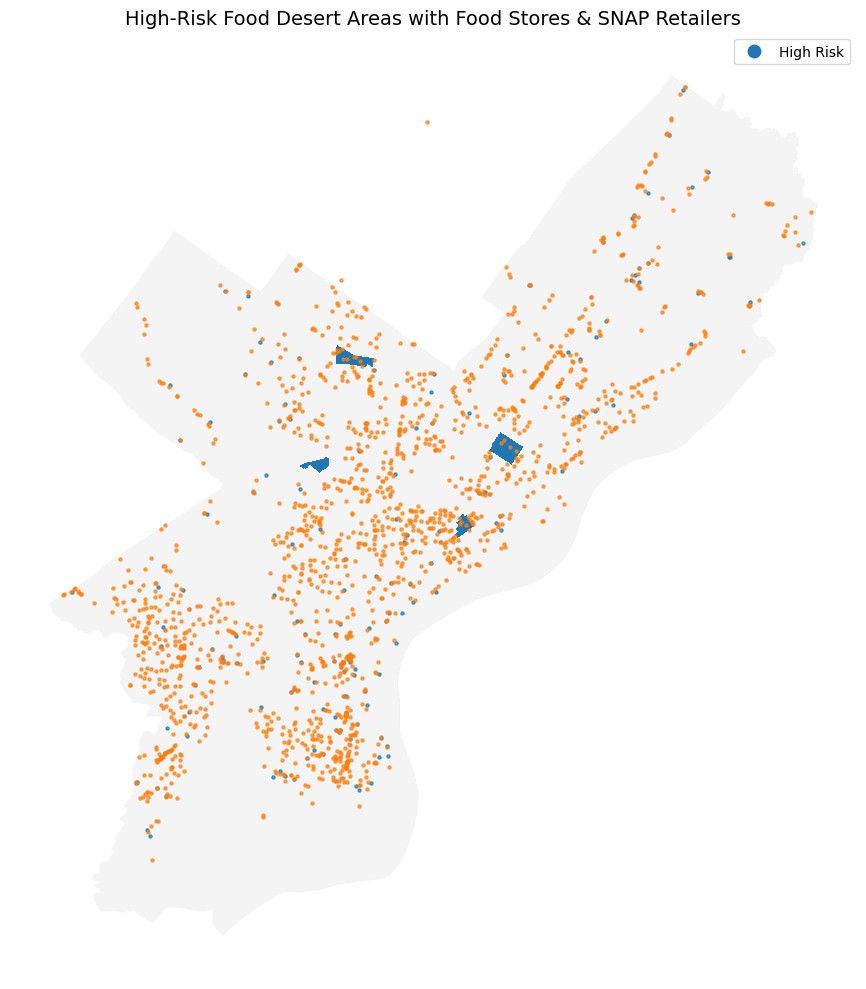

In [45]:
# Filter high-risk + severe cells
high_risk = grid_clean[grid_clean["food_desert_category"].isin(["High Risk", "Severe Food Desert"])]

# Make sure SNAP and food stores are in same CRS
snap_proj = snapgdf.to_crs(grid_clean.crs)
foodstore_proj = foodstore_proj.to_crs(grid_clean.crs)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Base: all grid cells (light)
grid_clean.plot(ax=ax, color="#eeeeee", linewidth=0, alpha=0.6)

# High-risk cells
high_risk.plot(
    ax=ax,
    column="food_desert_category",
    categorical=True,
    legend=True,
    linewidth=0
)

# Food stores and SNAP retailers
foodstore_proj.plot(ax=ax, markersize=5, alpha=0.7)
snap_proj.plot(ax=ax, markersize=5, alpha=0.7)

ax.set_title("High-Risk Food Desert Areas with Food Stores & SNAP Retailers", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()


Aggregate to census tracts: average index per tract

In [48]:
import geopandas as gpd

# 1. Start from the cleaned grid and ensure it has an active geometry
#    (the polygon grid cells)
grid_centroids = grid_clean.copy()
grid_centroids = grid_centroids.set_geometry("geometry")

# 2. Make sure grid and tracts are in the same CRS
#    merged_gdf already has tract geometries
grid_centroids = grid_centroids.to_crs(merged_gdf.crs)

# 3. Replace polygon geometry with centroids for the spatial join
#    (geometry column stays called "geometry", but now it's points)
grid_centroids["geometry"] = grid_centroids.geometry.centroid

# 4. Spatial join: which tract each grid cell centroid falls in
joined = gpd.sjoin(
    grid_centroids[["food_desert_index", "geometry"]],
    merged_gdf[["tract", "geometry"]],
    how="left",
    predicate="within"
)

# 5. Average food desert index per tract
tract_index = (
    joined
    .groupby("tract")["food_desert_index"]
    .mean()
    .reset_index()
)
tract_index.rename(
    columns={"food_desert_index": "food_desert_index_mean"},
    inplace=True
)

# 6. Merge back into tract polygons
tracts_with_index = merged_gdf.merge(
    tract_index,
    on="tract",
    how="left"
)

print("Finished aggregating. Columns now include 'food_desert_index_mean'.")


/var/folders/xm/lcfnqfw931d_v613yc9jpq480000gn/T/ipykernel_14203/812805674.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_centroids["geometry"] = grid_centroids.geometry.centroid


Finished aggregating. Columns now include 'food_desert_index_mean'.


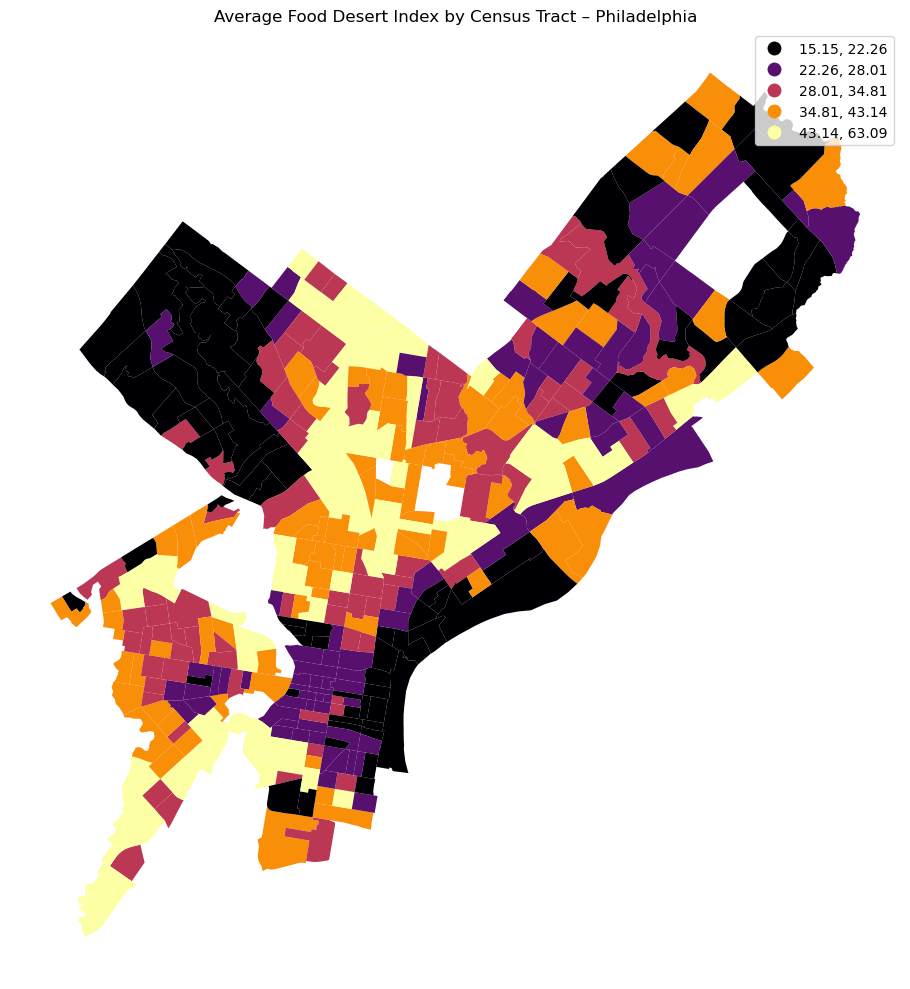

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

tracts_with_index.plot(
    column="food_desert_index_mean",
    cmap="inferno",
    scheme="quantiles",
    k=5,
    legend=True,
    ax=ax
)

ax.set_title("Average Food Desert Index by Census Tract – Philadelphia")
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [55]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from branca.colormap import LinearColormap
from IPython.display import HTML

# Convert to WGS84 + keep geometry
gdf = tracts_with_index.set_geometry("geometry").to_crs(epsg=4326)

# Get map center
center_y = gdf.geometry.centroid.y.mean()
center_x = gdf.geometry.centroid.x.mean()

m = folium.Map(location=[center_y, center_x], zoom_start=11)

# === Build Inferno colormap from matplotlib ===
vmin = gdf["food_desert_index_mean"].min()
vmax = gdf["food_desert_index_mean"].max()

# Use matplotlib inferno
inferno = cm.get_cmap("inferno", 256)

# Convert to HEX colors for folium
colors_list = [colors.rgb2hex(inferno(i)) for i in range(inferno.N)]

# Create folium colormap
colormap = LinearColormap(
    colors_list,
    vmin=vmin,
    vmax=vmax
)
colormap.caption = "Average Food Desert Index (0–100)"
colormap.add_to(m)

# === style + tooltip ===
def style_function(feature):
    val = feature["properties"].get("food_desert_index_mean")
    return {
        "fillColor": colormap(val) if val is not None else "#cccccc",
        "color": "black",
        "weight": 0.2,
        "fillOpacity": 0.7,
    }

tooltip = folium.GeoJsonTooltip(
    fields=[
        "tract",
        "food_desert_index_mean",
        "median_household_income",
        "poverty_rate",
        "unemployment_rate",
        "snap_rate",
    ],
    aliases=[
        "Tract:",
        "Food Desert Index (mean):",
        "Median HH Income:",
        "Poverty Rate (%):",
        "Unemployment Rate (%):",
        "SNAP Rate (%):",
    ],
    sticky=True,
)

folium.GeoJson(
    gdf,
    style_function=style_function,
    tooltip=tooltip,
).add_to(m)

HTML(m._repr_html_())


/var/folders/xm/lcfnqfw931d_v613yc9jpq480000gn/T/ipykernel_14203/3415471111.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_y = gdf.geometry.centroid.y.mean()
/var/folders/xm/lcfnqfw931d_v613yc9jpq480000gn/T/ipykernel_14203/3415471111.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_x = gdf.geometry.centroid.x.mean()
/var/folders/xm/lcfnqfw931d_v613yc9jpq480000gn/T/ipykernel_14203/3415471111.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  inferno = cm.get_cmap("inferno", 256)
